In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

In [4]:
data = yf.download(["NVDA", "SPY"], start= datetime.today() - timedelta(days = 1825), end = datetime.today(), auto_adjust = True)["Close"]
NVDA = data["NVDA"]
SPY = data["SPY"]

[*********************100%***********************]  2 of 2 completed


# 2

## i

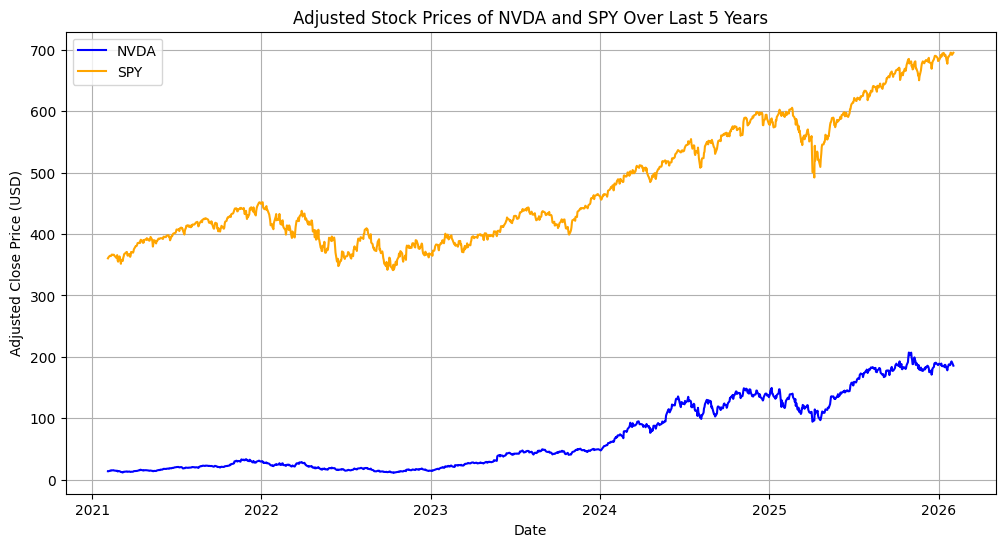

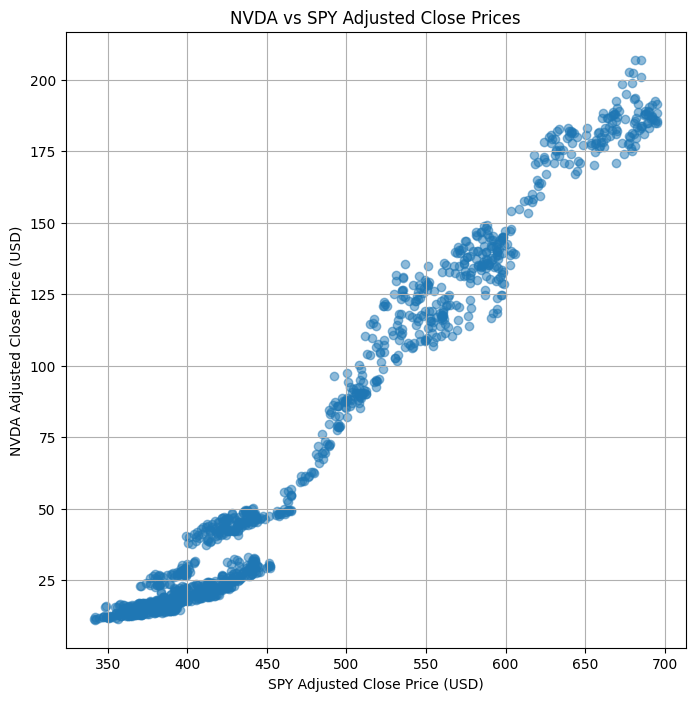

In [7]:
# plot adjusted stock prices as a function of time for both NVDA and SPY
plt.figure(figsize=(12, 6))
plt.plot(NVDA.index, NVDA.values, label='NVDA', color='blue')
plt.plot(SPY.index, SPY.values, label='SPY', color='orange')
plt.title('Adjusted Stock Prices of NVDA and SPY Over Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.grid()
plt.show()

# scatter plot of NVDA versus SPY on the same trading day
plt.figure(figsize=(8, 8))
plt.scatter(SPY.values, NVDA.values, alpha=0.5)
plt.title('NVDA vs SPY Adjusted Close Prices')
plt.xlabel('SPY Adjusted Close Price (USD)')
plt.ylabel('NVDA Adjusted Close Price (USD)')
plt.grid()
plt.show()

The two stock trends seem to be extremely similar, rising and dropping at
relatively the same times.

In [5]:
from statsmodels.api import OLS, add_constant
X = add_constant(SPY.values)
model = OLS(NVDA.values, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 4.089e+04
Date:                Tue, 03 Feb 2026   Prob (F-statistic):               0.00
Time:                        17:10:47   Log-Likelihood:                -4693.6
No. Observations:                1255   AIC:                             9391.
Df Residuals:                    1253   BIC:                             9401.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -211.7439      1.424   -148.724      0.0

**Intercept**: -211.8703, SE 1.425, p < 0.0001  
This is the predicted value of NVDA when SPY is valued at $0. This has no meaning 
in it of itself, however given its extremely low p-value, is obviously extremely 
relevant to the model as it anchors the regression line. The SE is also extremely
low, indicating a well estimated value.

**Coefficient**: 0.5929, SE 0.003, p < 0.0001  
For every $1 increase in SPY, NVDA is projected to increase by $0.5929. With 
an extremely low SE and p-value, this is a positive and highly significant correlation.

**R-Squared & Adjusted**: 0.970
This is extremely high, meaning that 97% of the variation in NVDA prices are
explained by SPY prices.

The very high R^2, t score, and confidence/p-value in the coefficients indicate
a strong linear correlation between NVDA and SPY price. However, the Durbin-Watson
score is 0.063. This is extremely low and a red flag in our model, as this indicates
extreme positive autocorrelation, violating the independent error assumption,
leading to an underestimation of the standard errors, which leads to inflated 
t-statistics and the false appearance of statistical significance. Thus,
while the conditional mean relationship is well approximated by a linear function, 
the error structure is misspecified. Consequently, we can also see that the 
omnibus and JB statistics indicate non Guassian residuals.

## ii

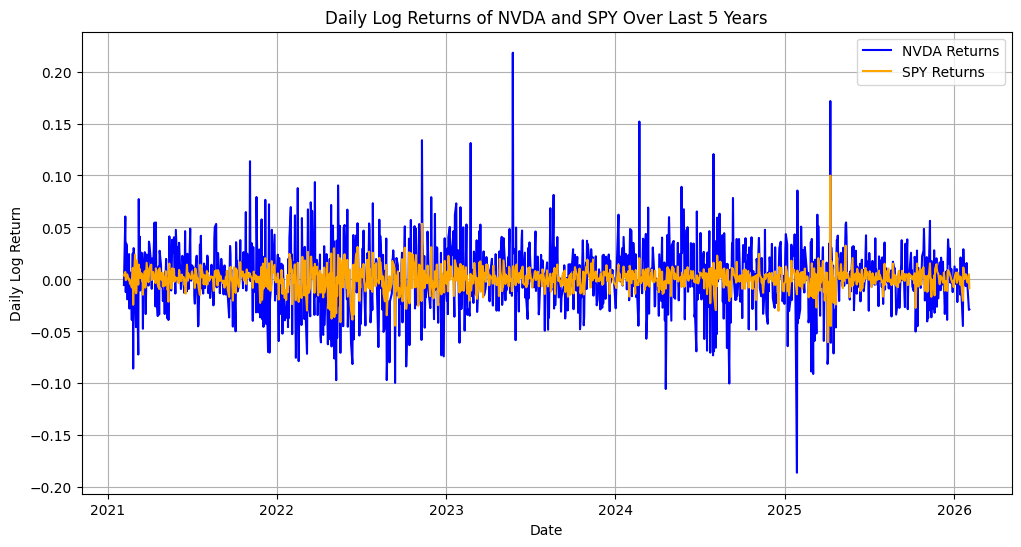

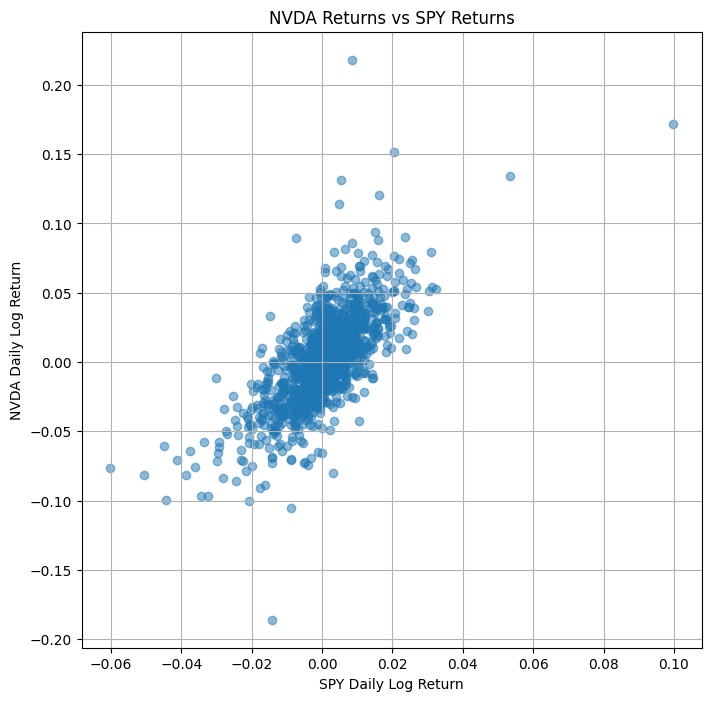

In [6]:
# daily log returns of NVDA and SPY
NVDA_returns = np.log(NVDA / NVDA.shift(1))
SPY_returns = np.log(SPY / SPY.shift(1))

# plot daily log returns for both NVDA and SPY
plt.figure(figsize=(12, 6))
plt.plot(NVDA_returns.index, NVDA_returns.values, label='NVDA Returns', color='blue')
plt.plot(SPY_returns.index, SPY_returns.values, label='SPY Returns', color='orange')
plt.title('Daily Log Returns of NVDA and SPY Over Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Daily Log Return')
plt.legend()
plt.grid()
plt.show()

# scatter plot of NVDA returns versus SPY returns on the same trading day
plt.figure(figsize=(8, 8))
plt.scatter(SPY_returns.values, NVDA_returns.values, alpha=0.5)
plt.title('NVDA Returns vs SPY Returns')
plt.xlabel('SPY Daily Log Return')
plt.ylabel('NVDA Daily Log Return')
plt.grid()
plt.show()

In [7]:
# fit CAPM regression r_theta_NVDA = alpha + beta * r_theta_SPY + epsilon_t
X_returns = add_constant(SPY_returns.values[1:])  # exclude NaN from shift
model_returns = OLS(NVDA_returns.values[1:], X_returns).fit()
print(model_returns.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     1228.
Date:                Tue, 03 Feb 2026   Prob (F-statistic):          5.00e-188
Time:                        17:10:53   Log-Likelihood:                 2944.5
No. Observations:                1254   AIC:                            -5885.
Df Residuals:                    1252   BIC:                            -5875.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.457      0.1

**Intercept**: 0.0010, SE 0.001, p 0.142  
This is the predicted value of daily return after accounting for market exposure.
This is expected as if there is no market activity, there shouldn't be any returns.
The p value also indicates it is statistically insignificant, which is also expected.

**Coefficient**: 2.1386, SE 0.061, p < 0.0001  
For every 1% daily return in SPY, NVDA is projected to return 2.14%. With a low
SE and low p-value, the coefficient is well estimated and statistically significant.

**R-Squared & Adjusted**: 0.495
About half of NVDA's daily returns variation is explained by SPY's returns.

There is no direct evidence of nonlinearity, even given a low R^2. The Durbin-Watson
statistic is also satisfactory, indicating no autocorrelation. However, the omnibus
and JB statistic still point to non-Gaussian residuals, but this doesn't directly
point to nonlinearity issues.

## iii

In [12]:
influence = model_returns.get_influence()
cooks_d = influence.cooks_distance[0]
influential_points = np.argsort(cooks_d)[-3:]
influential_dates = NVDA_returns.index[influential_points + 1]
print("Most influential observations (dates):")
for date in influential_dates:
    print(date.date())

Most influential observations (dates):
2025-01-27
2025-04-04
2025-04-09


**2025-01-27**: DeepSeek-R1 was released a week before, gaining global traction. 
Consequently, NVDA stocks dropped as investors were worried at how the low cost
model would impact leading AI companies such as Nvidia. [Reuters](https://www.reuters.com/technology/chinas-deepseek-sets-off-ai-market-rout-2025-01-27/?utm_source=chatgpt.com)

**2025-04-04**: Trump announces tariffs, leading to massive drops in the American
market. This obviously would affect SPY (S&P 500) companies disproportionately. 
NVDA would also feel pressure due to its global supply chain and from international
revenue.
[Reuters](https://www.reuters.com/markets/global-markets-wrapup-1-2025-04-04/?utm_source=chatgpt.com)

**2025-04-09**: The Trump administration announces the 90 day pause on a 
majority of the previously announced tariffs, leading to some market recovery 
as investors take this as a sign of deescalation / market relief. [NPR](https://www.npr.org/2025/04/09/nx-s1-5357405/stocks-tariffs-china-eu-trump-trade-war)

## iv

From (ii):
**Intercept**: 0.0010, SE 0.001, p 0.142  
This is the predicted value of daily return after accounting for market exposure.
This is expected as if there is no market activity, there shouldn't be any returns.
The p value also indicates it is statistically insignificant, which is also expected.

**Coefficient**: 2.1386, SE 0.061, p < 0.0001  
For every 1% daily return in SPY, NVDA is projected to return 2.14%. With a low
SE and low p-value, the coefficient is well estimated and statistically significant.

We are given the CAPM model:  
$$
\log\left(\frac{P_t^{\text{NVDA}}}{P_{t-1}^\text{NVDA}}\right) = \hat{\alpha} + \hat{\beta}\log\left(\frac{P_t^{\text{SPY}}}{P_{t-1}^\text{SPY}}\right) + \epsilon _t
$$
Exponentiating both sides gives:
$$
\frac{P_t^{\text{NVDA}}}{P_{t-1}^\text{NVDA}} = \exp(\hat{\alpha})\left(\frac{P_t^{\text{SPY}}}{P_{t-1}^\text{SPY}}\right)^{\hat{\beta}}\exp(\epsilon _t)
$$

Because $\hat{\alpha} \approx 0$, $\exp(\hat{\alpha}) \approx 1$. Then on a price scale, $\frac{\partial \log P_t^{\text{NVDA}}}{\partial \log P_t^{\text{SPY}}} = \hat{\beta} \approx 2.14$, thus we can see where a 1% increase in SPY's daily log returns is associated with a 2.14% increase in NVDA's daily log returns. $\hat{\beta}$ becomes an elasticity factor comparing SPY and NVDA returns.


## v

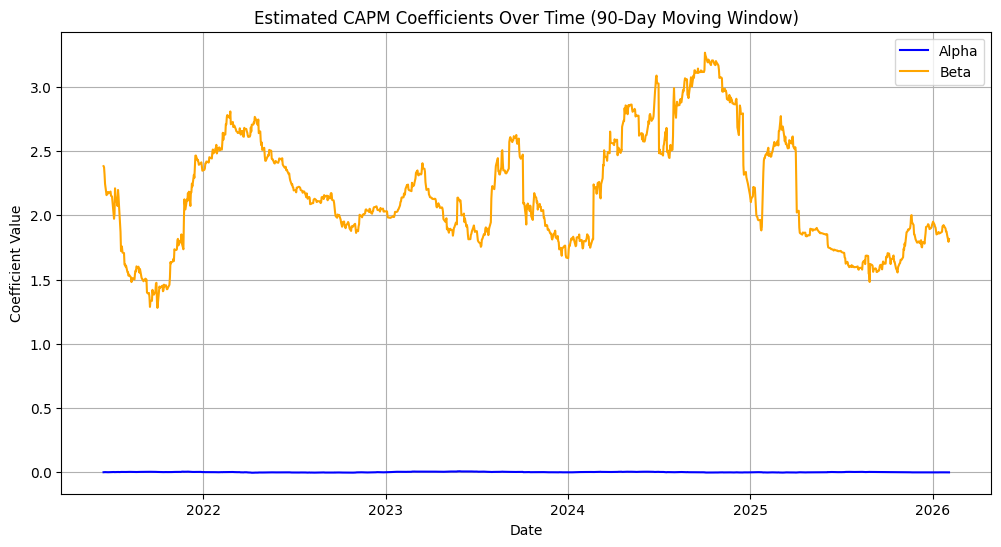

In [ ]:
window_size = 90
alphas = []
betas = []
dates = NVDA_returns.index[window_size:]
for i in range(len(NVDA_returns) - window_size):
    X_window = add_constant(SPY_returns.values[i+1:i+window_size+1])  # exclude NaN from shift
    y_window = NVDA_returns.values[i+1:i+window_size+1]
    model_window = OLS(y_window, X_window).fit()
    alphas.append(model_window.params[0])
    betas.append(model_window.params[1])

plt.figure(figsize=(12, 6))
plt.plot(dates, alphas, label='Alpha', color='blue')
plt.plot(dates, betas, label='Beta', color='orange')
plt.title('Estimated CAPM Coefficients Over Time (90-Day Moving Window)')
plt.xlabel('Date')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid()
plt.show()

We see that the beta value fluctuates over time, varying around 2, rising during technology booms around AI, and declining during market stress (initial COVID, slow recovery, Trump takes office, market fluctuations as found in part (iii)). The alpha (intercept) remains around zero, consistent with transitory firm-specific effects rather than sustained abnormal returns. These results indicate that NVDA’s relationship to the market is regime-dependent, violating the constant-beta assumption of the static CAPM and highlighting the importance of time-varying risk exposure.